In [1]:
# A whole lot of imports
import rasterio
import rasterio.transform
import rasterio.mask
import fiona
import shapely
import shapely.geometry
from shapely.geometry import MultiPolygon, Polygon
import pyproj

import pandas as pd

from matplotlib import pyplot as plt
import numpy as np
import mpl_toolkits.basemap as pbm

import rasterio.features
import rasterio.windows
from rasterio.windows import Window

In [2]:
# Raw code for masking a raster using the rasterio.mask.mask() function
# No longer part of rasterio package so should just be called by mask()
# Added feature where parameter out_dtype can be set
# and is fed into the out_dtype parameter of the read() function for reading a file


"""Mask the area outside of the input shapes with no data."""

import logging
import warnings

import numpy as np

from rasterio.errors import WindowError
from rasterio.features import geometry_mask, geometry_window


logger = logging.getLogger(__name__)


def raster_geometry_mask(dataset, shapes, all_touched=False, invert=False,
                         crop=False, pad=False, pad_width=0.5):
    """Create a mask from shapes, transform, and optional window within original
    raster.
    By default, mask is intended for use as a numpy mask, where pixels that
    overlap shapes are False.
    If shapes do not overlap the raster and crop=True, a ValueError is
    raised.  Otherwise, a warning is raised, and a completely True mask
    is returned (if invert is False).
    Parameters
    ----------
    dataset : a dataset object opened in 'r' mode
        Raster for which the mask will be created.
    shapes : iterable object
        The values must be a GeoJSON-like dict or an object that implements
        the Python geo interface protocol (such as a Shapely Polygon).
    all_touched : bool (opt)
        Include a pixel in the mask if it touches any of the shapes.
        If False (default), include a pixel only if its center is within one of
        the shapes, or if it is selected by Bresenham's line algorithm.
    invert : bool (opt)
        If False (default), mask will be `False` inside shapes and `True`
        outside.  If True, mask will be `True` inside shapes and `False`
        outside.
    crop : bool (opt)
        Whether to crop the dataset to the extent of the shapes. Defaults to
        False.
    pad : bool (opt)
        If True, the features will be padded in each direction by
        one half of a pixel prior to cropping dataset. Defaults to False.
    pad_width : float (opt)
        If pad is set (to maintain back-compatibility), then this will be the
        pixel-size width of the padding around the mask.
    Returns
    -------
    tuple
        Three elements:
            mask : numpy ndarray of type 'bool'
                Mask that is `True` outside shapes, and `False` within shapes.
            out_transform : affine.Affine()
                Information for mapping pixel coordinates in `masked` to another
                coordinate system.
            window: rasterio.windows.Window instance
                Window within original raster covered by shapes.  None if crop
                is False.
    """
    if crop and invert:
        raise ValueError("crop and invert cannot both be True.")

    if crop and pad:
        pad_x = pad_width
        pad_y = pad_width
    else:
        pad_x = 0
        pad_y = 0

    north_up = dataset.transform.e <= 0
    rotated = dataset.transform.b != 0 or dataset.transform.d != 0

    try:
        window = geometry_window(dataset, shapes, north_up=north_up, rotated=rotated,
                                 pad_x=pad_x, pad_y=pad_y)

    except WindowError:
        # If shapes do not overlap raster, raise Exception or UserWarning
        # depending on value of crop
        if crop:
            raise ValueError('Input shapes do not overlap raster.')
        else:
            warnings.warn('shapes are outside bounds of raster. '
                          'Are they in different coordinate reference systems?')

        # Return an entirely True mask (if invert is False)
        mask = np.ones(shape=dataset.shape[-2:], dtype='bool') * (not invert)
        return mask, dataset.transform, None

    if crop:
        transform = dataset.window_transform(window)
        out_shape = (int(window.height), int(window.width))

    else:
        window = None
        transform = dataset.transform
        out_shape = (int(dataset.height), int(dataset.width))

    mask = geometry_mask(shapes, transform=transform, invert=invert,
                         out_shape=out_shape, all_touched=all_touched)

    return mask, transform, window


def mask(dataset, shapes, all_touched=False, invert=False, nodata=None,
         filled=True, crop=False, pad=False, pad_width=0.5, indexes=None, out_dtype = None):
    """Creates a masked or filled array using input shapes.
    Pixels are masked or set to nodata outside the input shapes, unless
    `invert` is `True`.
    If shapes do not overlap the raster and crop=True, a ValueError is
    raised.  Otherwise, a warning is raised.
    Parameters
    ----------
    dataset : a dataset object opened in 'r' mode
        Raster to which the mask will be applied.
    shapes : iterable object
        The values must be a GeoJSON-like dict or an object that implements
        the Python geo interface protocol (such as a Shapely Polygon).
    all_touched : bool (opt)
        Include a pixel in the mask if it touches any of the shapes.
        If False (default), include a pixel only if its center is within one of
        the shapes, or if it is selected by Bresenham's line algorithm.
    invert : bool (opt)
        If False (default) pixels outside shapes will be masked.  If True,
        pixels inside shape will be masked.
    nodata : int or float (opt)
        Value representing nodata within each raster band. If not set,
        defaults to the nodata value for the input raster. If there is no
        set nodata value for the raster, it defaults to 0.
    filled : bool (opt)
        If True, the pixels outside the features will be set to nodata.
        If False, the output array will contain the original pixel data,
        and only the mask will be based on shapes.  Defaults to True.
    crop : bool (opt)
        Whether to crop the raster to the extent of the shapes. Defaults to
        False.
    pad : bool (opt)
        If True, the features will be padded in each direction by
        one half of a pixel prior to cropping raster. Defaults to False.
    indexes : list of ints or a single int (opt)
        If `indexes` is a list, the result is a 3D array, but is
        a 2D array if it is a band index number.
    Returns
    -------
    tuple
        Two elements:
            masked : numpy ndarray or numpy.ma.MaskedArray
                Data contained in the raster after applying the mask. If
                `filled` is `True` and `invert` is `False`, the return will be
                an array where pixels outside shapes are set to the nodata value
                (or nodata inside shapes if `invert` is `True`).
                If `filled` is `False`, the return will be a MaskedArray in
                which pixels outside shapes are `True` (or `False` if `invert`
                is `True`).
            out_transform : affine.Affine()
                Information for mapping pixel coordinates in `masked` to another
                coordinate system.
    """

    if nodata is None:
        if dataset.nodata is not None:
            nodata = dataset.nodata
        else:
            nodata = 0

    shape_mask, transform, window = raster_geometry_mask(
        dataset, shapes, all_touched=all_touched, invert=invert, crop=crop,
        pad=pad, pad_width=pad_width)

    if indexes is None:
        out_shape = (dataset.count, ) + shape_mask.shape
    elif isinstance(indexes, int):
        out_shape = shape_mask.shape
    else:
        out_shape = (len(indexes), ) + shape_mask.shape

    out_image = dataset.read(
        window=window, out_shape=out_shape, masked=True, indexes=indexes, out_dtype = out_dtype)

    out_image.mask = out_image.mask | shape_mask

    if filled:
        out_image = out_image.filled(nodata)

    return out_image, transform

In [3]:
# Used to warp from one coordinate system to another
# warping crs
def warp_xy(x, y, old_crs, new_crs):
    """Warps a set of points from old_crs to new_crs."""
    if old_crs == new_crs:
        return x,y

    old_crs_proj = pyproj.Proj(old_crs)
    new_crs_proj = pyproj.Proj(new_crs)
    return pyproj.transform(old_crs_proj, new_crs_proj, x,y)

def warp_shapely(shp, old_crs, new_crs):
    """Uses proj to reproject shapes, NOT IN PLACE"""
    if old_crs['init'] == new_crs['init']:
        return shp

    old_crs_proj = pyproj.Proj(old_crs)
    new_crs_proj = pyproj.Proj(new_crs)
    return shapely.ops.transform(lambda x,y:pyproj.transform(old_crs_proj, new_crs_proj, x,y), shp)

def warp_shape(feature, old_crs, new_crs):
    """Uses proj to reproject shapes, IN PLACE"""
    if old_crs == new_crs:
        return
    if len(feature['geometry']['coordinates']) is 0:
        return

    # find the dimension -- can't trust the shape
    dim = -1
    ptr = feature['geometry']['coordinates']
    done = False
    while not done:
        if hasattr(ptr, '__len__'):        
            assert(len(ptr) is not 0)
            dim += 1
            ptr = ptr[0]
        else:
            done = True

    if dim == 0:
        # point
        x,y = warp_xy(np.array([feature['geometry']['coordinates'][0],]), np.array([feature['geometry']['coordinates'][1],]), old_crs, new_crs)
        feature['geometry']['coordinates'][0] = x[0]
        feature['geometry']['coordinates'][1] = x[1]
    elif dim == 1:
        # line-like or polygon with no holes
        coords = np.array(feature['geometry']['coordinates'],'d')
        assert(len(coords.shape) is 2 and coords.shape[1] in [2,3] )
        x,y = warp_xy(coords[:,0], coords[:,1], old_crs, new_crs)
        new_coords = [xy for xy in zip(x,y)]
        feature['geometry']['coordinates'] = new_coords
    elif dim == 2:
        # multi-line or polygon with holes
        for i in range(len(feature['geometry']['coordinates'])):
            coords = np.array(feature['geometry']['coordinates'][i],'d')
            assert(len(coords.shape) is 2 and coords.shape[1] in [2,3])
            x,y = warp_xy(coords[:,0], coords[:,1], old_crs, new_crs)
            new_coords = [xy for xy in zip(x,y)]
            feature['geometry']['coordinates'][i] = new_coords
    elif dim == 3:
        # multi-polygon
        for i in range(len(feature['geometry']['coordinates'])):
            for j in range(len(feature['geometry']['coordinates'][i])):
                coords = np.array(feature['geometry']['coordinates'][i][j],'d')
                assert(len(coords.shape) is 2 and coords.shape[1] in [2,3])
                x,y = warp_xy(coords[:,0], coords[:,1], old_crs, new_crs)
                new_coords = [xy for xy in zip(x,y)]
                feature['geometry']['coordinates'][i][j] = new_coords

In [4]:
# importing all the data that we will be using

def filter_msas(cbsas):
    # Finds which cbsas are major and classify as MSAs
    # Also omits msas from Puerto Rico, Hawaii, and Alaska
    # msas is a list that contains the shapes for each MSA in the lower 48 states
    msas = []
    for cbsa in cbsas:
        cbsa_type = cbsa['properties']['LSAD']
        if cbsa_type == 'M1':
            if 'PR' not in cbsa['properties']['NAME'] and 'HI' not in cbsa['properties']['NAME'] and 'AK' not in cbsa['properties']['NAME']:
                msas.append(cbsa)
    return msas

def filter_test(cbsas):
    msas = filter_msas(cbsas)
    tests = msas[0:7]+[msas[13], msas[31], msas[121]]
    return tests

def filter_first_100(cbsas):
    msas = filter_msas(cbsas)
    tests = msas[0:100]
    return tests

def filter_name(cbsas):
    msas = filter_msas(cbsas)
    name = input()
    name_msas = [msa for msa in msas if name in msa['properties']['NAME']]
    assert(len(name_msas) == 1)
    return name_msas

# import and potentially warp all U.S. CBSA shapes
def load_cbsas(file=r'..\Data (Used)\tl_2017_us_cbsa\tl_2017_us_cbsa.shp', crs=None, filter=None):
    with fiona.open(file, 'r') as fid:
        cbsas = list(fid)
        cbsas_profile = fid.profile
    #print("We found {} CBSA shapes".format(len(cbsas)))
    #print('What CRS are we working in?')
    #print('  crs of CBSAs:', cbsas_profile['crs'])
    if filter is not None:
        cbsas = filter(cbsas)
    
    if crs is not None:
        for shp in cbsas:
            warp_shape(shp, cbsas_profile['crs'], crs) 
    cbsas_profile['crs'] = crs
    return cbsas, cbsas_profile



In [5]:
def box_on_msa(msa_shapely, path):
    """Takes in an MSA and data raster and returns a box of the data from the raster"""
    with rasterio.open(path) as fid:
        transform = fid.profile['transform']
        msa_bounds = msa_shapely.bounds
        ll = msa_bounds[0], msa_bounds[1]
        ur = msa_bounds[2], msa_bounds[3]
        ij_ll = tuple(reversed(rasterio.transform.rowcol(transform, *ll)))
        ij_ur = tuple(reversed(rasterio.transform.rowcol(transform, *ur)))
        boxed_msa = fid.read(1, window = ((ij_ur[1], ij_ll[1]), (ij_ll[0], ij_ur[0])))
    return boxed_msa, msa_bounds

def mask_on_msa(msa_shapely, path):
    """Returns raster data masked and cropped to an MSA"""
    with rasterio.open(path) as fid:
        array, transform = mask(fid, [msa_shapely,], crop=True, nodata = np.nan, out_dtype = rasterio.float32)
    return array[0,:,:], msa_shapely.bounds

def get_raster_on_msa(msa, path, extent=box_on_msa):
    """Takes in an MSA and raster file path and plots them."""
    msa_shapely = shapely.geometry.shape(msa['geometry'])
    if msa['geometry']['type'] == 'Polygon':
        x,y = msa_shapely.exterior.xy
        #plt.plot(x,y)
    else:
        for poly in msa_shapely:
            x,y = poly.exterior.xy
            #plt.plot(x,y)
    
    boxed_msa, msa_bounds = extent(msa_shapely, path)
    return boxed_msa

In [6]:
# import the impervious surface raster
def get_crs(path):
    with rasterio.open(path, 'r') as fid:
        crs = fid.profile['crs']
        #print(crs)
    return crs

path_imp = r'..\Data (Used)\NLCD_2016_Impervious_L48_20190405\NLCD_2016_Impervious_L48_20190405.img'
path_pop = r'..\Data (Used)\popdynamics-pop-projection-ssp-downscaled-1km-2010-2100-ssp2-geotiff\SSP2_1km\ssp2_total_2010.tif'


In [7]:
def plot_msa(path, msa, mask_type):
    boxed_msa = get_raster_on_msa(msa, path, mask_type)
    plt.imshow(boxed_msa)
    plt.show()

def load_and_plot(path, filter, mask_type):
    crs = get_crs(path)
    msas, profile = load_cbsas(crs=crs, filter=filter)
    for msa in msas:
        plot_msa(path, msa, mask_type)

In [8]:
def load_and_analyze(path, filter, mask_type):
    crs = get_crs(path)
    msas, profile = load_cbsas(crs=crs, filter=filter)
    colnames = ['Name', 'Area of Land', 'Number of pixels', 'Number of nan pixels', 'Data sum']
    df = pd.DataFrame(columns=colnames)
    data_array = []
    for msa in msas:
        boxed_msa = get_raster_on_msa(msa, path, mask_type)
        name = msa['properties']['NAME']
        
        """Finds the amount of land in an MSA and passes it out"""
        a_land = msa['properties']['ALAND']

        """Finds the number of pixels that lie within the msa"""
        num_pixels = np.where(np.isnan(boxed_msa), 0, 1).sum()
        
        """Sums the number of nan pixels in the raster given"""
        num_nan_pixels = np.where(np.isnan(boxed_msa), 1, 0).sum()
                                      
        """Adds all of the bounded data fractions within the msa"""
        data_sum = np.where(np.isnan(boxed_msa), 0, boxed_msa).sum()

        """Finds the number of pixels that have a value greater than (x)"""
        gt = np.where(np.greater(boxed_msa, 85000), 1, 0).sum()
    
        """Puts together an array for the data to be put into a dataframe"""
        data = [name, a_land, num_pixels, num_nan_pixels, data_sum]
        data_array.append(data)
    df2 = pd.DataFrame(data=data_array, columns=colnames)
    return df2

Philadelphia


C:\Users\moranedw000\.conda\envs\gis\lib\site-packages\ipykernel_launcher.py:24: RuntimeWarning: invalid value encountered in greater


                                          Name  Area of Land  \
0  Philadelphia-Camden-Wilmington, PA-NJ-DE-MD   11920554988   

   Number of pixels  Number of nan pixels   Data sum  
0             18769                 16751  6307826.0  
Philadelphia


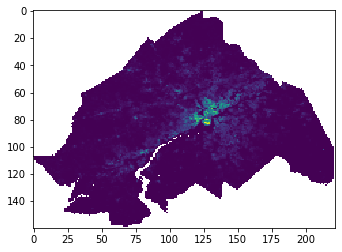

In [9]:
df_pop_test = load_and_analyze(path_pop, filter_name, mask_on_msa)
print(df_pop_test)
load_and_plot(path_pop, filter_name, mask_on_msa)

In [10]:
df_imp = load_and_analyze(path_imp, filter_msas, mask_on_msa)
df_pop = load_and_analyze(path_pop, filter_msas, mask_on_msa)

C:\Users\moranedw000\.conda\envs\gis\lib\site-packages\ipykernel_launcher.py:24: RuntimeWarning: invalid value encountered in greater


In [11]:
print(df_imp)
print(df_pop)

                                    Name  Area of Land  Number of pixels  \
0                          Rochester, MN    6415412346           7211905   
1                            Raleigh, NC    5485063049           6180040   
2                         Rapid City, SD   20213988388          22522307   
3                          Rochester, NY    8459578202          15096002   
4                            Reading, PA    2218035729           2491442   
..                                   ...           ...               ...   
373            Daphne-Fairhope-Foley, AL    4117605847           5834130   
374  Davenport-Moline-Rock Island, IA-IL    5878605797           6658673   
375                           Dayton, OH    3320520332           3713055   
376                          Decatur, AL    3289461477           3787855   
377                          Decatur, IL    1503973504           1685991   

     Number of nan pixels    Data sum  
0                 5657745  11693057.0  
1      

In [12]:
def load_and_plot_area_vs_pop(path, filter, mask_type):
    crs = get_crs(path)
    msas, profile = load_cbsas(crs=crs, filter=filter)

In [13]:
df_pop.to_csv("pop_dataframe.csv", index=False)
df_pop.to_csv("imp_dataframe.csv", index=False)

find which msas which have a imp surf to pop pixel ratio between 50 and 300 and replot??||||
add up population of each msa||||
df to csv file||||df col1 = cbsa code#, col2 = cbsa name||||add data files to github repository
update population year path name (path_pop) needs to be more distinguished + download more data from the site

Findings:
The number of nan pixels and normal pixels in a masked msa do not add up to the number of pixels in an unmasked msa